In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
import yaml
import janitor as pj
import matplotlib.pyplot as plt
import numpy as np
import gensim
from gensim import corpora, models
from gensim.corpora import Dictionary, MmCorpus
from gensim.models import Phrases, LdaModel
from gensim.test.utils import datapath
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pickle

C:\Users\jeffw\miniforge3\envs\unhcr_speeches\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [2]:
!dvc pull

Everything is up to date.


### Descriptive Statistics

In [3]:
# Pull in data

df = pd.read_feather('data/descriptive')

In [4]:
# Quick check top words

pd.DataFrame(df.speech.value_counts().head(20))

,speech
international,5407
problem,5119
humanitarian,4741
people,4610
government,4442
protection,4346
need,4234
office,4207
solution,3691
new,3493


In [641]:
### Generate top word counts by commissioner

freq = pd.DataFrame(df.groupby('speaker')['speech']
                        .value_counts()
                        .groupby(level=0, group_keys=False).head(10)
                       )
freq.columns = ['freq']
freq = freq.reset_index()
freq.columns = ['speaker', 'word', 'freq']

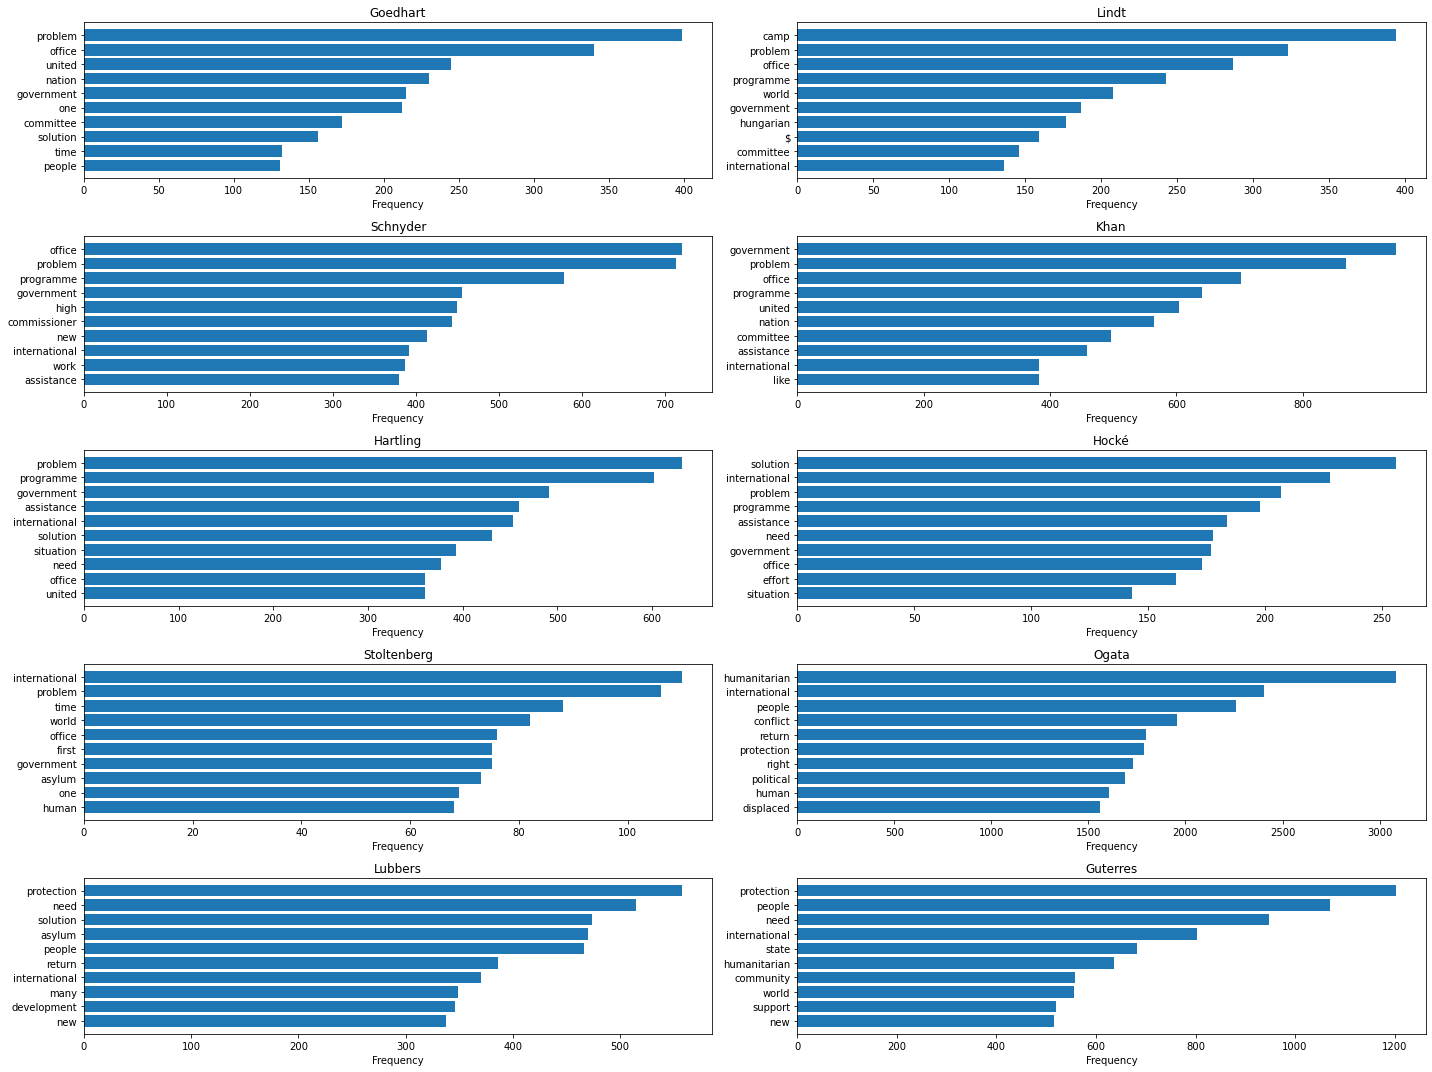

In [642]:
### Plot word frequencies by commissioner

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2, figsize=(20, 15))

speaker = ['Goedhart', 
           'Lindt', 
           'Schnyder', 
           'Khan', 
           'Hartling', 
           'Hocké', 
           'Stoltenberg', 
           'Ogata', 
           'Lubbers', 
           'Guterres']
j = 1

for n in speaker:
    a = eval('ax' + str(j))
    
    y_pos = freq[freq.speaker == n].word
    
    count = freq[freq.speaker == n].freq
    
    a.barh(y_pos, count)
    
    a.set_yticks(y_pos, labels=freq[freq.speaker == n].word)
    a.invert_yaxis()
    a.set_xlabel('Frequency')
    a.set_title(n)
    
    j = j + 1

plt.tight_layout()

In [643]:
freq = pd.DataFrame(df.groupby('decade')['speech']
                        .value_counts()
                        .groupby(level=0, group_keys=False).head(10)
                       )
freq.columns = ['freq']
freq = freq.reset_index()
freq.columns = ['decade', 'word', 'freq']

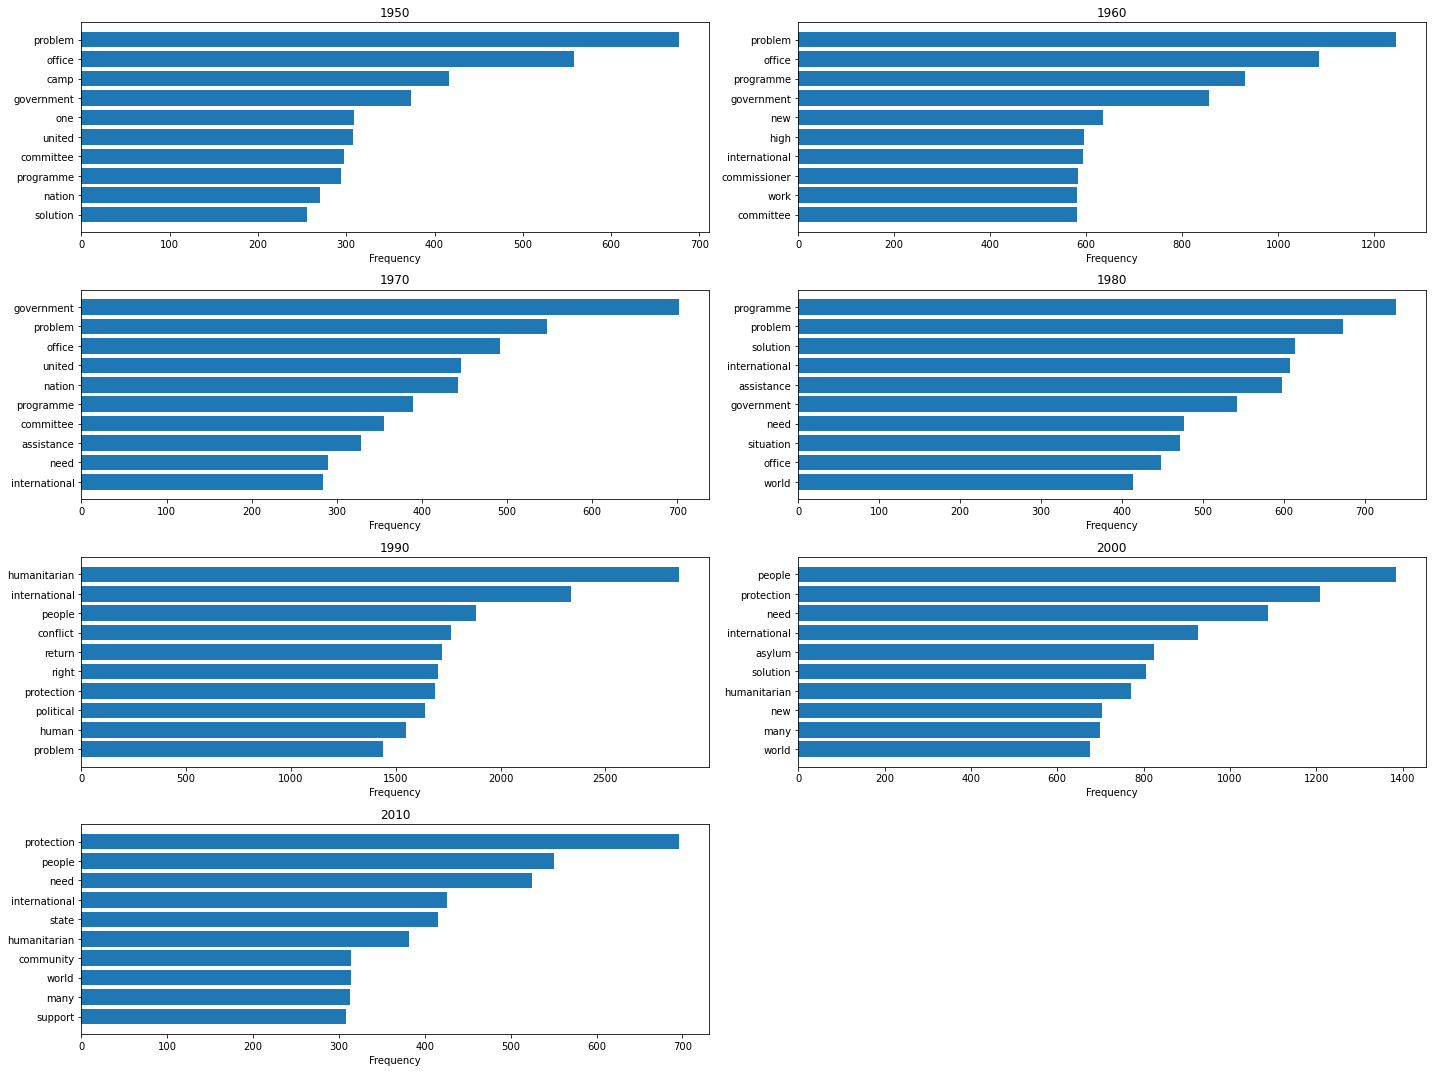

In [644]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(20, 15))

j = 1
decade = [1950, 1960, 1970, 1980, 1990, 2000, 2010]

for n in decade:
    a = eval('ax' + str(j))
    
    y_pos = freq[freq.decade == n].word
    
    count = freq[freq.decade == n].freq
    
    a.barh(y_pos, count)
    
    a.set_yticks(y_pos, labels=freq[freq.decade == n].word)
    a.invert_yaxis()
    a.set_xlabel('Frequency')
    a.set_title(n)
    
    j = j + 1

fig.delaxes(ax8)
plt.tight_layout()

### Topic Model

In [5]:
# Pull in model

topic_model = gensim.models.ldamodel.LdaModel.load('lda_model')
dictionary = corpora.Dictionary.load('speech.dict')
corpus = corpora.MmCorpus('speech.mm')
with open('data/docs', 'rb') as fp:
    docs = pickle.load(fp)
with open('data/docs_tagged', 'rb') as fp:
    docs_tagged = pickle.load(fp)

In [6]:
vis_data = gensimvis.prepare(topic_model, corpus, dictionary)

C:\Users\jeffw\miniforge3\envs\unhcr_speeches\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [7]:
pyLDAvis.display(vis_data)

In [8]:
topic_model.print_topics()

[(0,
  '0.010*"asia" + 0.009*"cpa" + 0.008*"region" + 0.007*"asylum" + 0.006*"vietnam" + 0.006*"million" + 0.006*"political" + 0.005*"vietnamese" + 0.005*"resettlement" + 0.005*"comprehensive"'),
 (1,
  '0.008*"syrian" + 0.008*"syria" + 0.007*"child" + 0.007*"crisis" + 0.007*"conflict" + 0.006*"million" + 0.005*"region" + 0.005*"border" + 0.005*"host" + 0.004*"international_community"'),
 (2,
  '0.010*"programme" + 0.006*"committee" + 0.006*"africa" + 0.005*"nation" + 0.004*"development" + 0.004*"general" + 0.004*"million" + 0.004*"may" + 0.003*"voluntary" + 0.003*"person"'),
 (3,
  '0.006*"development" + 0.004*"process" + 0.004*"staff" + 0.004*"displaced" + 0.004*"unhcrs" + 0.004*"million" + 0.004*"challenge" + 0.003*"displacement" + 0.003*"asylum" + 0.003*"approach"'),
 (4,
  '0.025*"asylum" + 0.013*"europe" + 0.011*"right" + 0.010*"european" + 0.008*"convention" + 0.008*"nansen" + 0.007*"nation" + 0.005*"seeker" + 0.005*"asylum_seeker" + 0.005*"system"'),
 (5,
  '0.025*"return" + 0.

In [9]:
# Pull in topics over time 

topics_over_time = pd.read_feather('data/topics_over_time')

In [10]:
topics_over_time

,year,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9,topic 10
0,1951,0.000000,0.000000,0.057376,0.003085,0.232673,0.000000,0.053485,0.600119,0.026294,0.025185
1,1952,0.000000,0.005084,0.062091,0.000000,0.062845,0.000000,0.000000,0.802714,0.000000,0.062542
2,1953,0.000000,0.006265,0.000000,0.000000,0.090903,0.000000,0.000000,0.771485,0.003407,0.126784
3,1954,0.000000,0.000000,0.030756,0.000000,0.160084,0.000000,0.008570,0.775207,0.007491,0.015918
4,1955,0.000000,0.006133,0.053345,0.000000,0.382695,0.000000,0.000000,0.494064,0.000000,0.060262
...,...,...,...,...,...,...,...,...,...,...,...
59,2010,0.002058,0.076333,0.023575,0.737604,0.101157,0.000000,0.028434,0.018888,0.000000,0.010804
60,2011,0.006165,0.193977,0.047091,0.538053,0.058020,0.025354,0.079257,0.039790,0.000000,0.011004
61,2012,0.009810,0.281148,0.009801,0.512704,0.044971,0.000000,0.034066,0.039878,0.001123,0.062420
62,2013,0.006317,0.509260,0.001080,0.387939,0.022473,0.005568,0.021869,0.010067,0.001896,0.032017


In [11]:
x = topics_over_time['year'].astype(int) + 1970
y1 = topics_over_time['topic 1']
y2 = topics_over_time['topic 2']
y3 = topics_over_time['topic 3']
y4 = topics_over_time['topic 4']
y5 = topics_over_time['topic 5']
y6 = topics_over_time['topic 6']
y7 = topics_over_time['topic 7']
y8 = topics_over_time['topic 8']
y9 = topics_over_time['topic 9']
y10 = topics_over_time['topic 10']

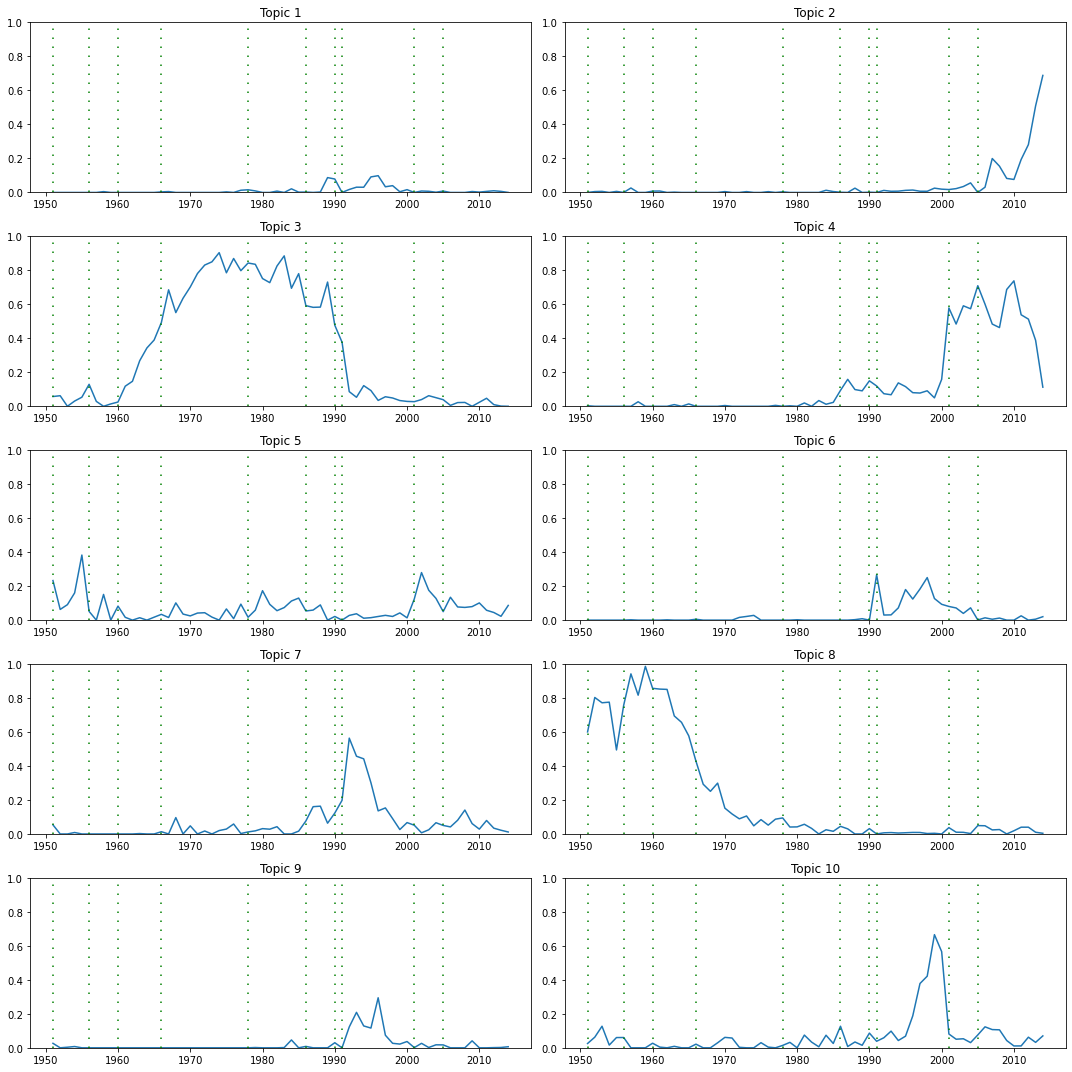

In [40]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2, figsize=(15, 15))

for j in range(1, 11):
    a = eval('ax' + str(j))
    y = eval('y' + str(j)) 
    title = 'Topic' + ' ' + str(j)
    a.plot(x, y)
    a.set_title(title)
    a.set(ylim=(0, 1))
    a.axvline(x= 1951, color='green', linestyle=(0, (1, 5)))
    a.axvline(x= 1956, color='green', linestyle=(0, (1, 5)))
    a.axvline(x= 1960, color='green', linestyle=(0, (1, 5)))
    a.axvline(x= 1966, color='green', linestyle=(0, (1, 5)))
    a.axvline(x= 1978, color='green', linestyle=(0, (1, 5)))
    a.axvline(x= 1986, color='green', linestyle=(0, (1, 5)))
    a.axvline(x= 1990, color='green', linestyle=(0, (1, 5)))
    a.axvline(x= 1991, color='green', linestyle=(0, (1, 5)))
    a.axvline(x= 2001, color='green', linestyle=(0, (1, 5)))
    a.axvline(x= 2005, color='green', linestyle=(0, (1, 5)))

plt.tight_layout()

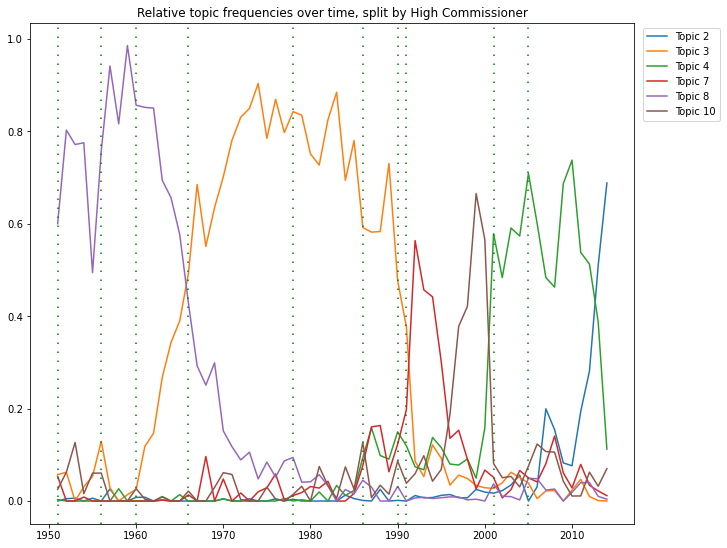

In [61]:
plt.figure(figsize=(10, 7.5), layout = 'constrained')
# plt.plot(x, y1, label = 'Topic 1')
plt.plot(x, y2, label = 'Topic 2')
plt.plot(x, y3, label = 'Topic 3')
plt.plot(x, y4, label = 'Topic 4')
#plt.plot(x, y5, label = 'Topic 5')
#plt.plot(x, y6, label = 'Topic 6')
plt.plot(x, y7, label = 'Topic 7')
plt.plot(x, y8, label = 'Topic 8')
#plt.plot(x, y9, label = 'Topic 9')
plt.plot(x, y10, label = 'Topic 10')
plt.axvline(x= 1951, color='green', linestyle=(0, (1, 5)))
plt.axvline(x= 1956, color='green', linestyle=(0, (1, 5)))
plt.axvline(x= 1960, color='green', linestyle=(0, (1, 5)))
plt.axvline(x= 1966, color='green', linestyle=(0, (1, 5)))
plt.axvline(x= 1978, color='green', linestyle=(0, (1, 5)))
plt.axvline(x= 1986, color='green', linestyle=(0, (1, 5)))
plt.axvline(x= 1990, color='green', linestyle=(0, (1, 5)))
plt.axvline(x= 1991, color='green', linestyle=(0, (1, 5)))
plt.axvline(x= 2001, color='green', linestyle=(0, (1, 5)))
plt.axvline(x= 2005, color='green', linestyle=(0, (1, 5)))
plt.legend(bbox_to_anchor=(1.15,1))
plt.title("Relative topic frequencies over time, split by High Commissioner")
plt.show()